In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

In [ ]:
!unzip 'drive/MyDrive/COMP3710/OASIS.zip' -d 'sample_data/data/'

串流輸出內容已截斷至最後 5000 行。
  inflating: sample_data/data/OASIS/case_287_slice_30.nii.png  
  inflating: sample_data/data/OASIS/case_287_slice_31.nii.png  
  inflating: sample_data/data/OASIS/case_287_slice_4.nii.png  
  inflating: sample_data/data/OASIS/case_287_slice_5.nii.png  
  inflating: sample_data/data/OASIS/case_287_slice_6.nii.png  
  inflating: sample_data/data/OASIS/case_287_slice_7.nii.png  
  inflating: sample_data/data/OASIS/case_287_slice_8.nii.png  
 extracting: sample_data/data/OASIS/case_287_slice_9.nii.png  
  inflating: sample_data/data/OASIS/case_288_slice_0.nii.png  
  inflating: sample_data/data/OASIS/case_288_slice_1.nii.png  
  inflating: sample_data/data/OASIS/case_288_slice_10.nii.png  
  inflating: sample_data/data/OASIS/case_288_slice_11.nii.png  
  inflating: sample_data/data/OASIS/case_288_slice_12.nii.png  
  inflating: sample_data/data/OASIS/case_288_slice_13.nii.png  
  inflating: sample_data/data/OASIS/case_288_slice_14.nii.png  
  inflating: sample_data/da

In [1]:
import random
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import torch 
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader,SubsetRandomSampler
from torchvision import datasets, transforms
from torchsummary import summary
import pickle as pkl

In [ ]:
dataroot = f'sample_data/data'
nc=1
b_size=32
dataset=datasets.ImageFolder(
    root=dataroot,
    transform=transforms.Compose([
        transforms.Resize([256,256]) #[image_size,image_size]->resize H and W, image_size->resize W
        ,transforms.ToTensor()
        ,transforms.Grayscale(1) #reduce the channel number to 1 to make the calculation faster
        ,transforms.Normalize(0.5,0.5) #rescale the range of input values to -1~1(from 0~1)
        ]))

In [ ]:
dataloader=DataLoader(dataset,num_workers=0,batch_size=b_size,shuffle=True)

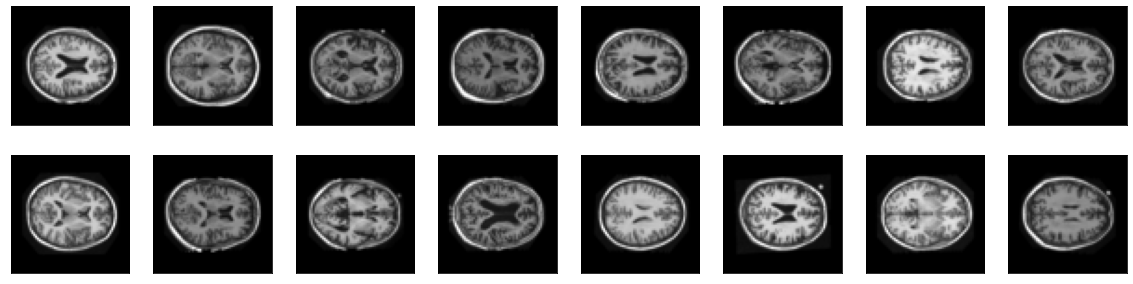

In [ ]:
dataiter=iter(dataloader)
images,labels=dataiter.next()

def Gshow(img): #show gray scale images
  img_=img.numpy()
  img_=img.reshape(img_.shape[1],img_.shape[2]) #reshape from 64*64*1 to 64*64 as imshow(cmap='gray) only takes two values
  plt.imshow(img_,cmap='gray')# 256*256

plot_only=16 #plot only 16 images
fig=plt.figure(1,figsize=(20,5))
for idx in range(plot_only):
  ax=fig.add_subplot(2,plot_only/2,idx+1,xticks=[],yticks=[])
  Gshow(images[idx])

In [ ]:
"""
learned from:
https://github.com/lernapparat/lernapparat/blob/master/style_gan/pytorch_style_gan_test_discriminator.ipynb
https://github.com/aladdinpersson/Machine-Learning-Collection/blob/master/ML/Pytorch/GANs/StyleGAN/model.py
https://github.com/facebookresearch/pytorch_GAN_zoo/tree/b75dee40918caabb4fe7ec561522717bf096a8cb/models/networks
"""

In [2]:
class WScaledConv(nn.Module): #output shape tested
  """
  Weight scaled conv2d,
  customized lr is not implemented
  """
  def __init__(self, ins, outs, k_size=3, stride=1, padding=1):
    #super(WScaledConv, self).__init__()
    super().__init__()
    self.k_size = k_size
    self.stride = stride
    self.padding = padding

    #gain is usually set to 2**0.5 as default
    self.scale = (2/(k_size*k_size*ins))**(1/2) #torch
    self.wscaled = torch.nn.Parameter(torch.randn(outs, ins, k_size, k_size)*self.scale)
    self.bias = torch.nn.Parameter(torch.zeros(outs))
  def forward(self, x):
    return F.conv2d(x, self.wscaled, self.bias, stride=self.stride, padding=self.padding)

In [3]:
class WScaledLinear(nn.Module): #output shape tested
  """
  Weight scaled Linear,
  customized lr is not implemented
  """
  def __init__(self, ins=512, outs=512):
    #super(WScaledLinear, self).__init__()
    super().__init__()
    self.ins=ins
    self.outs=outs

    self.scale=(2/ins)**(1/2)
    self.wscaled=torch.nn.Parameter(torch.randn(outs, ins)*self.scale)
    self.bias=torch.nn.Parameter(torch.zeros(outs))
  def forward(self, x):
    return F.linear(x, self.wscaled, self.bias)

In [113]:
class PixelNorm(nn.Module): #output shape tested
  """
  for proGAN this is used in every block
  for styleGAN this is used only in the mapping network
  """
  def __init__(self, epsilon=1e-8):
    #super(PixelNorm, self).__init__()
    super().__init__()
    self.epsilon=epsilon
  def forward(self, x):
    #normalize by avearage value across dimension 1 plus epsilon
    #print(x)
    x_=(x*x).mean(dim=1,keepdim=True)+self.epsilon
    return x/(x_**0.5)

In [4]:
class MappingNet(nn.Module): #output shape tested
  """
  the 8-dense-layers net, projecting latent z(ins) to w(outs)
  PixelNorm is merged into here
  """
  def __init__(self,ins=512,outs=512,n_layers=8):
    super().__init__()
    self.mapping=nn.ModuleList()
    #self.mapping.append(PixelNorm())
    self.mapping.append(WScaledLinear(ins,outs))
    for i in range(n_layers-1):
      self.mapping.append(nn.ReLU())
      self.mapping.append(WScaledLinear(outs,outs))
  def forward(self, x):
    #PixelNorm
    x_=(x*x).mean(dim=1,keepdim=True)+1e-8 #epsilon=1e-8
    x=x/(x_**0.5)
    #8 dense layers
    for model in self.mapping:
      x=model(x)
    return x

In [5]:
class AdaIN(nn.Module): #output shape tested
  """
  Adaptive Instance Norm
  latent w required for using "style", use WScaledLinear(ins(w), outs(c))
  where w is the #-output of the mapping net and c is the #-output channels of the previous layer
  """
  def __init__(self, ins=512, outs=512): 
    #super(AdaIN, self).__init__()
    super().__init__()
    self.insnorm=nn.InstanceNorm2d(outs,affine=True)# facebookresearch uses eps=1e-08
    self.style_wfactor=WScaledLinear(ins,outs)
    self.style_bias=WScaledLinear(ins,outs)
  def forward(self, x, w):
    #latent w is the output of the mapping net
    #x is the output of the previous layer
    size=x.size()
    style_wf=self.style_wfactor(w).view(size[0],size[1],1,1)
    style_b=self.style_bias(w).view(size[0],size[1],1,1)
    return x*style_wf+style_b
    #return self.insnorm(x)


In [6]:
class Gblock(nn.Module): #output shape tested
  """
  Generative block,
  each block contains one upscale layer and two conv layers (except for the initial block)  
  """
  def __init__(self, initial=False, ins=512, outs=512, b_size=32):
    #super(Gblock, self).__init__()
    super().__init__()
    self.initial=initial
    self.ins=ins
    self.outs=outs
    self.b_size=b_size
    #self.z2w=MappingNet()
    if self.initial:
      self.const=nn.Parameter(torch.ones((b_size,ins,4,4)))
    else:
      self.conv1=WScaledConv(ins=self.ins,outs=self.outs)
    self.ada1=AdaIN(outs=outs)
    self.conv2=WScaledConv(ins=self.outs,outs=self.outs)
    self.ada2=AdaIN(outs=outs)
    self.lkrelu=nn.LeakyReLU(0.2,inplace=True)
  def upscale(self, x):
    return F.interpolate(x,scale_factor=2) #bilinear?

  def forward(self, x, w):
    if self.initial:
      x=self.const
      #constant
      #or one dense layer for random inputs
    else:
      x=self.upscale(x)#upscale
      x=self.conv1(x)#conv1(WScaled)
      x=self.lkrelu(x)
      #add noise
    #w1=self.z2w(noise)
    x=self.ada1(x,w)#AdaIn

    x=self.conv2(x)
    x=self.lkrelu(x)
    #add noise
    #w2=self.z2w(noise)
    x=self.ada2(x,w)#AdaIn
    return x

In [11]:
noise=torch.randn(32,512)
mp=MappingNet()
noise=mp(noise)
Gblk1=Gblock(initial=True)
Gblk2=Gblock(ins=512,outs=256)
Gblk3=Gblock(ins=256,outs=128)
Gblk4=Gblock(ins=128,outs=64)
Gblk5=Gblock(ins=64,outs=32)
Gblk6=Gblock(ins=32,outs=16)
Gblk7=Gblock(ins=16,outs=8)
a=Gblk1(x=None,w=noise)
print(a.shape)
b=Gblk2(x=a,w=noise)
print(b.shape)
c=Gblk3(x=b,w=noise)
print(c.shape)
d=Gblk4(x=c,w=noise)
print(d.shape)
e=Gblk5(x=d,w=noise)
print(e.shape)
f=Gblk6(x=e,w=noise)
print(f.shape)
g=Gblk7(x=f,w=noise)
print(g.shape)

torch.Size([32, 512, 4, 4])
torch.Size([32, 256, 8, 8])
torch.Size([32, 128, 16, 16])
torch.Size([32, 64, 32, 32])
torch.Size([32, 32, 64, 64])
torch.Size([32, 16, 128, 128])
torch.Size([32, 8, 256, 256])


In [7]:
class Gnet(nn.Module):
  """
  the generator,
  input: noise of size batch_size*num_features, 32*512
  output: image of size batch_size*num_channels*H*W, 32*1*256*256
  #-blocks = 7 [0 1 2 3 4 5 6]
  #-features= [ 512), 512, 256, 128, 64, 32, 16, 8 ]
  img_size = [ 4const), 4, 8, 16, 32, 64, 128, 256 ]
  """
  def __init__(self, epochs=[20,20,20,25,25,30,30],b_size=32, nc=1):
    super().__init__()
    #total #-batches is 354
    n_features=[512, 256, 128, 64, 32, 16, 8]
    self.steps=0
    #self.noise=noise
    self.b_size=b_size
    self.epochs=epochs

    self.alpha=1.0
    self.alpha_decay=2.26e-4
    self.cur_sacle=0
    
    self.z2w=MappingNet()
    self.Gblocks=nn.ModuleList()
    self.Gblocks.append(Gblock(initial=True))
    for i in range(7-1):
      self.Gblocks.append(Gblock(ins=n_features[i],outs=n_features[i+1]))
    
    self.toImg=nn.ModuleList()
    for i in range(7):
      self.toImg.append(WScaledConv(ins=n_features[i],outs=nc,k_size=1,stride=1,padding=0))
    #self.Gblk1=Gblock(initial=True)
    #self.Gblk2=Gblock(ins=512,outs=256)
    #self.Gblk3=Gblock(ins=256,outs=128)
    #self.Gblk4=Gblock(ins=128,outs=64)
    #self.Gblk5=Gblock(ins=64,outs=32)
    #self.Gblk6=Gblock(ins=32,outs=16)
    #self.Gblk7=Gblock(ins=16,outs=8)
  def fadeIn(self, x_cur=None, x_pre=None):
    last=self.toImg[self.steps](x_cur)
    if self.alpha>0:
      Sndlast=self.toImg[self.steps-1](x_pre)
      Sndlast=F.interpolate(Sndlast,scale_factor=2)
      return self.alpha*Sndlast+(1-self.alpha)*last
    else:
      return last
  def forward(self, noise, alpha, steps):
    self.steps=steps
    self.alpha=alpha
    w=self.z2w(noise)
    if self.steps==0:
      return self.toImg[0](self.Gblocks[0](x=None,w=w))
    else:
      for i in range(0,self.steps+1):
        if i==0:
          x=self.Gblocks[0](x=None,w=w)
        else:
          x=self.Gblocks[i](x,w)

        if i==self.steps-1:
          x_=x
        print(i,x.shape)      
      return self.fadeIn(x_cur=x, x_pre=x_)

In [81]:
G=Gnet()
noise=torch.randn(32,512)
a=G(noise,alpha=0.5,steps=6)
a.shape

0 torch.Size([32, 512, 4, 4])
1 torch.Size([32, 256, 8, 8])
2 torch.Size([32, 128, 16, 16])
3 torch.Size([32, 64, 32, 32])
4 torch.Size([32, 32, 64, 64])
5 torch.Size([32, 16, 128, 128])
6 torch.Size([32, 8, 256, 256])


torch.Size([32, 1, 256, 256])

In [ ]:
G=Gnet()
noise=torch.randn(32,512)
alpha=0
for i in range(30):
  a=G(noise,alpha=alpha,steps=6)
  print(a.shape)
  alpha+=0.05

In [39]:
class Dblock(nn.Module):
  """
  input: image b*c*H*W(32,1,H,W)
  output: b*n_features*H*W(32,n_features,H,W)
  minibatch_std not implemented yet
  """
  def __init__(self, initial=False, ins=512, outs=512, b_size=32):
    super().__init__()
    self.initial=initial
    self.ins=ins
    self.outs=outs
    self.b_size=b_size
    
    self.conv1=WScaledConv(self.ins,self.outs,k_size=3)
    if self.initial:
      self.conv2=WScaledConv(self.outs,self.outs,k_size=4,padding=0)
      self.conv3=WScaledConv(self.outs,1,k_size=1,padding=0)
    else:
      self.conv2=WScaledConv(self.outs,self.outs,k_size=3,padding=1)
      self.downscale=nn.AvgPool2d(kernel_size=2,stride=2)
    self.lkrelu=nn.LeakyReLU(0.2,inplace=True)
    
  def forward(self, x):
    x=self.lkrelu(self.conv1(x))
    x=self.lkrelu(self.conv2(x))
    if self.initial:
      x=self.conv3(x).view(self.b_size,-1)
    else:
      x=self.downscale(x)
    return x

In [40]:
n=torch.randn(32,8,256,256)
n_features=[8, 16, 32, 64, 128, 256, 512]
k=nn.ModuleList()
for i in range(7-1):
  k.append(Dblock(ins=n_features[i],outs=n_features[i+1]))
k.append(Dblock(initial=True))
print(n.shape)
for m in k:
  n=m(n)
  print(n.shape)

torch.Size([32, 8, 256, 256])
torch.Size([32, 16, 128, 128])
torch.Size([32, 32, 64, 64])
torch.Size([32, 64, 32, 32])
torch.Size([32, 128, 16, 16])
torch.Size([32, 256, 8, 8])
torch.Size([32, 512, 4, 4])
torch.Size([32, 1])


In [ ]:
class Dnet(nn.Module):
  """
  """
  def __init__(self, epochs=[20,20,20,25,25,30,30],b_size=32, nc=1):
    super().__init__()
    pass
  def fadeIn(self, x_cur=None, x_pre=None):
    pass
  def forward(self, noise, alpha, steps):
    pass